# An analysis of housing data in King County Washington.

### Presented by: Data Chef Partners

 Objective: To help realtors identify profitable areas in their chosen county so they can help their customers buy or sell with confidence<br>
#### Families:
- Get more hose for their money
- Make an investment for future gains 
- Possible rental opportunities<br>
#### Contractors
- identify hotspots for flip opportunities
- identify areas of future development for new construction ventures
- Find customers looking to rennovate<br>
#### Investors
- Identify the gold standard of house for investment opportunities


In [1]:
# Setting up the workspace by importing all of the necessary libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import folium
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import RFE
from sklearn import metrics
import scipy.stats as stats
warnings.filterwarnings('ignore')

### Custom Functions

In [2]:
# Building an OLS model with a summary output or just results
def make_ols_model(df, target='price', columns_to_use=None, add_constant=False, summary=False):
    X = df[columns_to_use]
    y = df[target]

    if add_constant:
        X = sm.add_constant(X)
    
    model = sm.OLS(y, X)
    results = model.fit()
    if summary:
        print(results.summary())
    return model, results

# Linear regression plot
def lin_reg_plt(x=None, y=None, data=None):
    sns.lmplot(x=x, y=y, data=data, aspect=1, height=4)
    
def make_pairplot(columns=None, df=None):
    if columns is None:
        columns=['price', 'bedrooms', 'bathrooms', 'ren_period', 'sqft_living', 'floors', 'condition']
    if df is None:
        df = dff
    sns.pairplot(df, kind='scatter', vars=columns, height=2)
    plt.show()

    

## Loading the data

In [ ]:
make_pairplot()

In [ ]:
# Loading the data and getting a first look at it's structure and contents
df = pd.read_csv('kc_house_data.csv')
df.head(10)

In [ ]:
# Taking a look at the types of data and the information about the different columns
# Identifying extraneous values that may need to be removed or altered for cleaner processing
df.info()

In [ ]:
df.describe()

### Initial Data impressions:<br>
- __*id*__ is simply an identifier<br>
    This will be removed as it is not pertinent to the data analysis.<br>
- __*date*__ is a string.<br>
    Our initial impression is that it reflects sale dates for the property.<br>
    This should be converted to a numerical value for processing.<br>
- There are two columns related to the size, __*sqft_living and sqft_lot*__ <br>
    We will explore their relationship and determine if they are dependent on each other or not<br>
- __*floors*__ is a numerical value.<br>
    Based on our knowledge of houses we believe this may be better suited to a categorical value.<br>
    We will explore the data and convert it to either a single or multiple<br> 
    or decide if each value of floors needs it's own category.<br>
- __*waterfront*__ is definitely categorical sine a home can only be either on or off the water.<br>
    We will convert this to a binary value to represent either on or off the water.<br>
- __*sqft_basement*__ <br>
    This along with __*sqft_above*__ combined are the same as __*sqft_living*__ so we will drop it<br>
    from the dataset since the presence of a basement is more significant than the size.<br>
    'sqft_basement will then be converted to categories which will identify the presence of a basement<br>
- __*zipcode*__ and __*lat long*__ are both location data.<br>
    We will determine if both are necessary and treat them accordingly<br>
- __*yr_renovated*__ has many null values so they will be replaced.<br>
    we will replace both the null values and all 0's with the original year built.


### Scrubbing the Data!!

*Waterfront*

In [ ]:
# 'waterfront' is either True "1" or False "0".
# here we are changing all of the Null values to 0 to facilitate this
df['waterfront'] = df.waterfront.fillna(0)

*ID*

In [ ]:
# 'id' is an arbitrary value which is unnecesary for analysis
# here we are removing it from the dataset
df.drop(['id'], axis=1, inplace=True)



*View*

In [ ]:
# 'view' has some null values, so we will replace those with the assumption
#  that the null values represent the property not being viewed.
df['view'] = df.view.fillna(value = 0)

   *Sqft_basement*

In [ ]:
# 'sqft_basement' has some placeholders. Here we are removing those
# This also needs to be converted to numerical values for analysis
df.sqft_basement.replace(to_replace='?', value='0', inplace=True)
df.sqft_basement = df.sqft_basement.convert_objects(convert_numeric=True)

In [ ]:
df['yr_renovated'] = df.yr_renovated.fillna(value = 0)
df.yr_renovated = df.yr_renovated.replace(to_replace=0, value=df.yr_built)
    
        

In [ ]:
df['ren_period'] = 2015-df.yr_renovated

In [ ]:
df.ren_period.plot(kind='hist', bins=30)

In [ ]:
df.head()

In [ ]:
# converting to datetime for analysis
df['yr_renovated_dt'] = pd.to_datetime(df.yr_renovated.astype(int), format='%Y').dt.year
df.head(10)

In [ ]:
# converting 'date' to datetime format for processing
df['date_dt'] = pd.to_datetime(df.date)
df.head()

### Looking over the Clean, Shiny Data.

In [ ]:
df.describe()

## Saving cleaned DF as a CSV file for future use

In [ ]:
df.to_csv("cleaned_kc_house_data.csv", index=False)

In [3]:
dff = pd.read_csv("cleaned_kc_house_data.csv")

In [4]:
# Taking an initial look at the basic statistics of the data set
dff.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ren_period,yr_renovated_dt,date_dt
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,...,1955,1955.0,98178,47.5112,-122.257,1340,5650,60.0,1955,2014-10-13
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,...,1951,1991.0,98125,47.7210,-122.319,1690,7639,24.0,1991,2014-12-09
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,...,1933,1933.0,98028,47.7379,-122.233,2720,8062,82.0,1933,2015-02-25
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,...,1965,1965.0,98136,47.5208,-122.393,1360,5000,50.0,1965,2014-12-09
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,...,1987,1987.0,98074,47.6168,-122.045,1800,7503,28.0,1987,2015-02-18


## Visualizing the Data

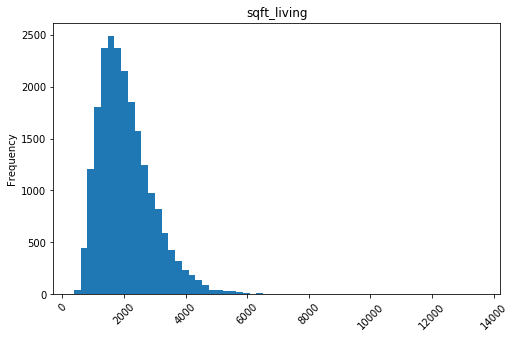

In [5]:
dff.sqft_living.plot(kind='hist', bins=60, title='sqft_living', figsize=(8,5), rot='45')

in the histogram above:
- __*sqft_living*__ as graphed above seems to indicate that the majority of the houses in this
    dataset are between 1000 sqft and 3000 sqft.
- There is a large amount between 3000 and 4500 which may be significant

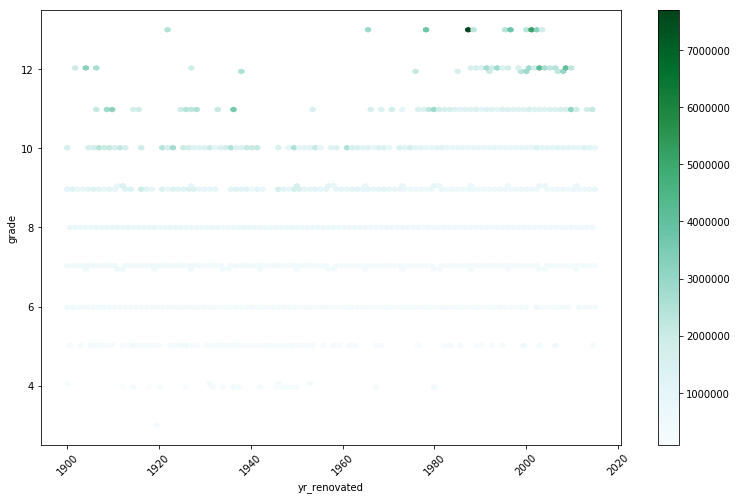

In [6]:
dff.plot.hexbin(x='yr_renovated', y='grade', C='price', figsize=(13,8),sharex=False, rot=45, legend=True)

In the hexbin plot above: 
- it appears that as the __*grade*__ of the house increases, the __*price*__ of the house also increases.
- It also appears that the __*yr_renovated*__ does not have much impact on the grade.

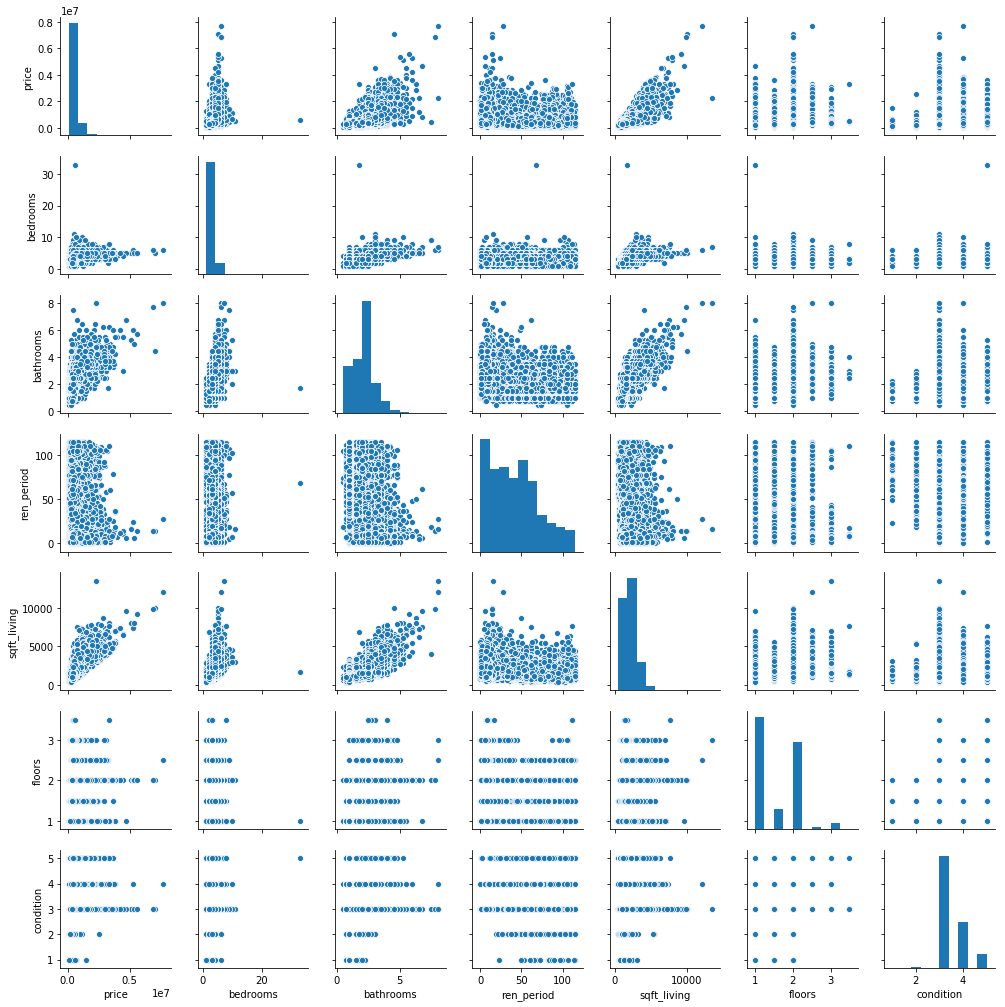

In [8]:

cols=['price', 'bedrooms', 'bathrooms', 'ren_period', 'sqft_living', 'floors', 'condition']
sns.pairplot(dff, kind='scatter', vars=cols, height=2)


In the above pairplot, the following observations were made:
- __*bedrooms*__ seems to have a relationship with __*price,sqft_living, and bathrooms*__.
- __*sqft_lliving*__ and __*price*__ seem to have a linear relationship
- __*sqft_living and bathrooms*__ seem to have a direct correlation to each other.
- there are a few outliers that appear to be skewing the data, we will need to remove those.

#### Outliers have been identified and we will remove those for analysis
- __*bathrooms*__ above 10
- __*bedrooms*__ above 10
- __*sqft_living*__ above 10000

In [9]:
dff_working = dff.loc[(dff['bathrooms']< 10) & (dff['bedrooms']<10) & (dff['sqft_living']<10000)]

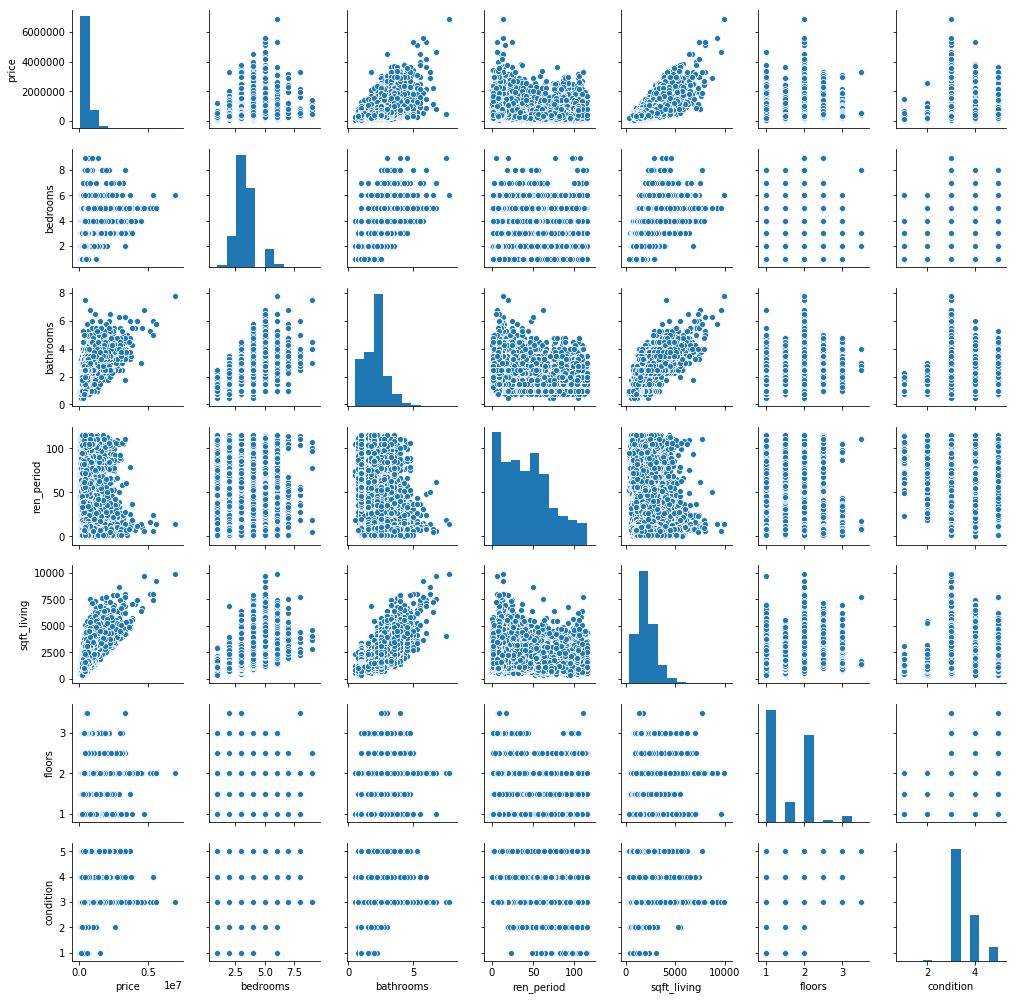

In [10]:
make_pairplot(df=dff_working)

#### It appears that the cleaning we have done was successful.<br>


Text(0.5, 1.0, 'Price vs 1st group of column variables')

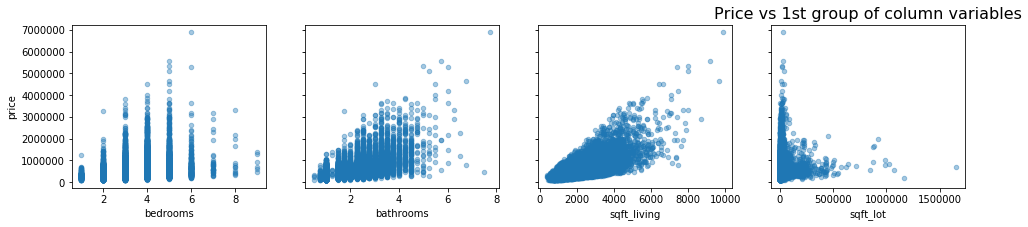

In [11]:

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for xcol, ax in zip(list(dff_working)[2:6], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)

plt.title('Price vs 1st group of column variables', fontsize = 16)


Text(0.5, 1.0, 'Price vs 1st group of column variables')

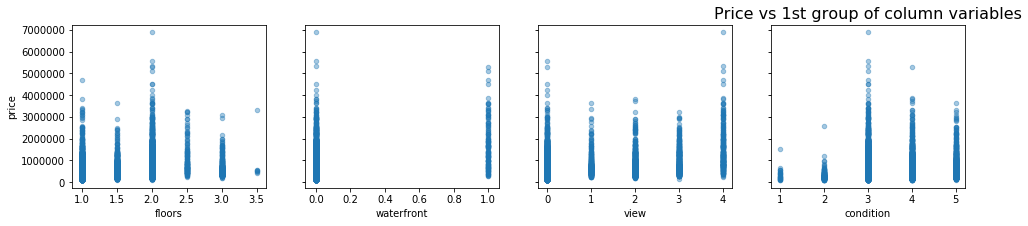

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for xcol, ax in zip(list(dff_working)[6:10], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)

plt.title('Price vs 1st group of column variables', fontsize = 16)

Text(0.5, 1.0, 'Price vs 1st group of column variables')

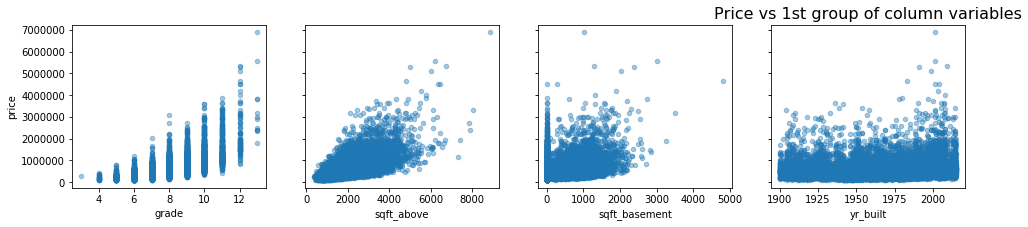

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(16,3))
for xcol, ax in zip(list(dff_working)[10:14], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4, sharey=True)

plt.title('Price vs 1st group of column variables', fontsize = 16)

Text(0.5, 1.0, 'Price vs 1st group of column variables')

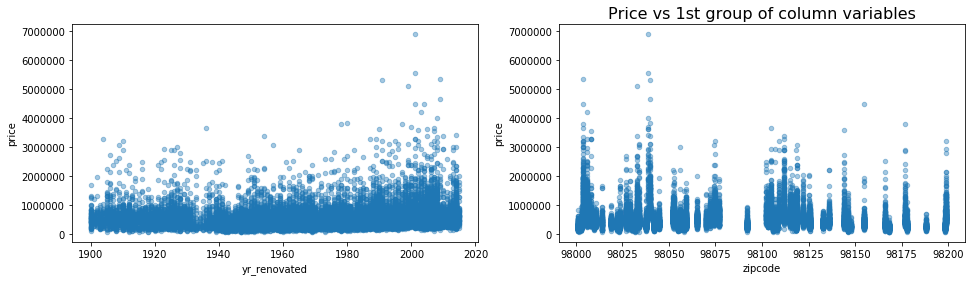

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
for xcol, ax in zip(list(dff_working)[14:16], axes):
                    dff_working.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=.4)

plt.title('Price vs 1st group of column variables', fontsize = 16)


### Looking at the plots above, we have determined that we will look further into:
- __*bathrooms*__
- __*sqft_living*__
- __*bedrooms*__
- __*lat & long*__ <br>
as they relate to our target __*price*__

### Now to check for Mulitcolilnearity
 using the Pearson test, we can look for high correlation between two variables<br>
 to determine if they represent the same data.<br> 
 We will look at the values at 75% or higher and determine if we should drop one 

In [17]:
dff_working.corr()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ren_period,yr_renovated_dt
price,1.000000,0.317445,0.525034,0.699558,0.089231,0.258236,0.259684,0.394149,0.036505,0.672626,...,0.314938,0.057417,0.097733,-0.053363,0.310742,0.022726,0.589759,0.082453,-0.097733,0.097733
bedrooms,0.317445,1.000000,0.527954,0.595037,0.032688,0.183341,-0.002951,0.079254,0.023476,0.367447,...,0.301024,0.163067,0.170661,-0.158882,-0.012267,0.137545,0.405936,0.030967,-0.170661,0.170661
bathrooms,0.525034,0.527954,1.000000,0.754499,0.086118,0.502753,0.062393,0.183069,-0.126782,0.665281,...,0.273268,0.509581,0.533497,-0.205103,0.023763,0.225344,0.569228,0.086071,-0.533497,0.533497
sqft_living,0.699558,0.595037,0.754499,1.000000,0.170669,0.354074,0.101072,0.278520,-0.059742,0.764354,...,0.422625,0.321915,0.340843,-0.200676,0.051592,0.242690,0.758302,0.181681,-0.340843,0.340843
sqft_lot,0.089231,0.032688,0.086118,0.170669,1.000000,-0.005774,0.021279,0.073502,-0.008603,0.113621,...,0.012073,0.052721,0.051595,-0.129571,-0.085877,0.229984,0.143557,0.717510,-0.051595,0.051595
floors,0.258236,0.183341,0.502753,0.354074,-0.005774,1.000000,0.020369,0.027531,-0.264182,0.458551,...,-0.244838,0.489864,0.500910,-0.059516,0.049101,0.125929,0.279584,-0.011709,-0.500910,0.500910
waterfront,0.259684,-0.002951,0.062393,0.101072,0.021279,0.020369,1.000000,0.381008,0.017076,0.081610,...,0.081094,-0.024004,-0.007462,0.029800,-0.012553,-0.037765,0.082606,0.030566,0.007462,-0.007462
view,0.394149,0.079254,0.183069,0.278520,0.073502,0.027531,0.381008,1.000000,0.045862,0.247552,...,0.267902,-0.054495,-0.027224,0.085498,0.006001,-0.078151,0.277595,0.071513,0.027224,-0.027224
condition,0.036505,0.023476,-0.126782,-0.059742,-0.008603,-0.264182,0.017076,0.045862,1.000000,-0.146956,...,0.169248,-0.361547,-0.390135,0.002774,-0.015220,-0.105733,-0.092964,-0.002854,0.390135,-0.390135
grade,0.672626,0.367447,0.665281,0.764354,0.113621,0.458551,0.081610,0.247552,-0.146956,1.000000,...,0.162896,0.448716,0.459400,-0.185750,0.113410,0.200366,0.713415,0.119925,-0.459400,0.459400


In [18]:
abs(dff_working.corr()) >.75


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,ren_period,yr_renovated_dt
price,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bedrooms,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
bathrooms,False,False,True,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
sqft_living,False,False,True,True,False,False,False,False,False,True,...,False,False,False,False,False,False,True,False,False,False
sqft_lot,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
floors,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
waterfront,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
view,False,False,False,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,False
condition,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
grade,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False


- It looks like grade may be correlated with 'sqft_living', but this relationship should be expected
- 'bathrooms' and 'sqft_living15' seem to be correlated.<br>
  upon further inspection it seems to indicate that 'sqft_living15' may be the size before remodeling and sqft_living is     the current size.<br>
  We will look at this closer<br>
- It looks like 'lat' and 'long' may have some importance, but they need to be used together.<br>
  We will separate them out for further inspection.

In [23]:
dff_working.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21589 entries, 0 to 21596
Data columns (total 23 columns):
date               21589 non-null object
price              21589 non-null float64
bedrooms           21589 non-null int64
bathrooms          21589 non-null float64
sqft_living        21589 non-null int64
sqft_lot           21589 non-null int64
floors             21589 non-null float64
waterfront         21589 non-null float64
view               21589 non-null float64
condition          21589 non-null int64
grade              21589 non-null int64
sqft_above         21589 non-null int64
sqft_basement      21589 non-null float64
yr_built           21589 non-null int64
yr_renovated       21589 non-null float64
zipcode            21589 non-null int64
lat                21589 non-null float64
long               21589 non-null float64
sqft_living15      21589 non-null int64
sqft_lot15         21589 non-null int64
ren_period         21589 non-null float64
yr_renovated_dt    21589 non-n

In [25]:
cols = ['bedrooms', 'bathrooms', 'ren_period', 'sqft_living', 'floors', 'condition']
cols = dff_working.drop(columns=['date', 'date_dt', 'price']).columns
make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.702
Model:                            OLS   Adj. R-squared:                  0.702
Method:                 Least Squares   F-statistic:                     2828.
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        09:44:18   Log-Likelihood:            -2.9383e+05
No. Observations:               21589   AIC:                         5.877e+05
Df Residuals:                   21570   BIC:                         5.879e+05
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
bedrooms        -3.691e+04   1955.693    -

(<statsmodels.regression.linear_model.OLS at 0x22689461fd0>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x226894619b0>)

### Summary 1: All Columns
- Model
    - R2 is 70.2
        - but given the **multicollinearity** this number is highly unreliable
- Features
    - Our coefficients are also unreliable, since we have such high multicollinearity
    - Pvalues are all under 0.05
- Residuals
    - Skewed to the right, which means our line is below our data
    - Kurtosis is very high, which means our data is far away (35 standard deviations) from the line
    - Condition Number is infinity, which means we have multicollinearity

In [37]:
cols = ['grade', 'lat', 'condition']

make_ols_model(df=dff_working, columns_to_use=cols, summary=True)

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                 3.633e+04
Date:                Wed, 30 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:03:58   Log-Likelihood:            -3.0014e+05
No. Observations:               21589   AIC:                         6.003e+05
Df Residuals:                   21586   BIC:                         6.003e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
grade       2.123e+05   1553.181    136.684      0.0

(<statsmodels.regression.linear_model.OLS at 0x22682980828>,
 <statsmodels.regression.linear_model.RegressionResultsWrapper at 0x22682980748>)

In [ ]:
sns.lmplot(x='price', y='bathrooms', data=dff_working)

### Looking for and removing Multi_Colinearity

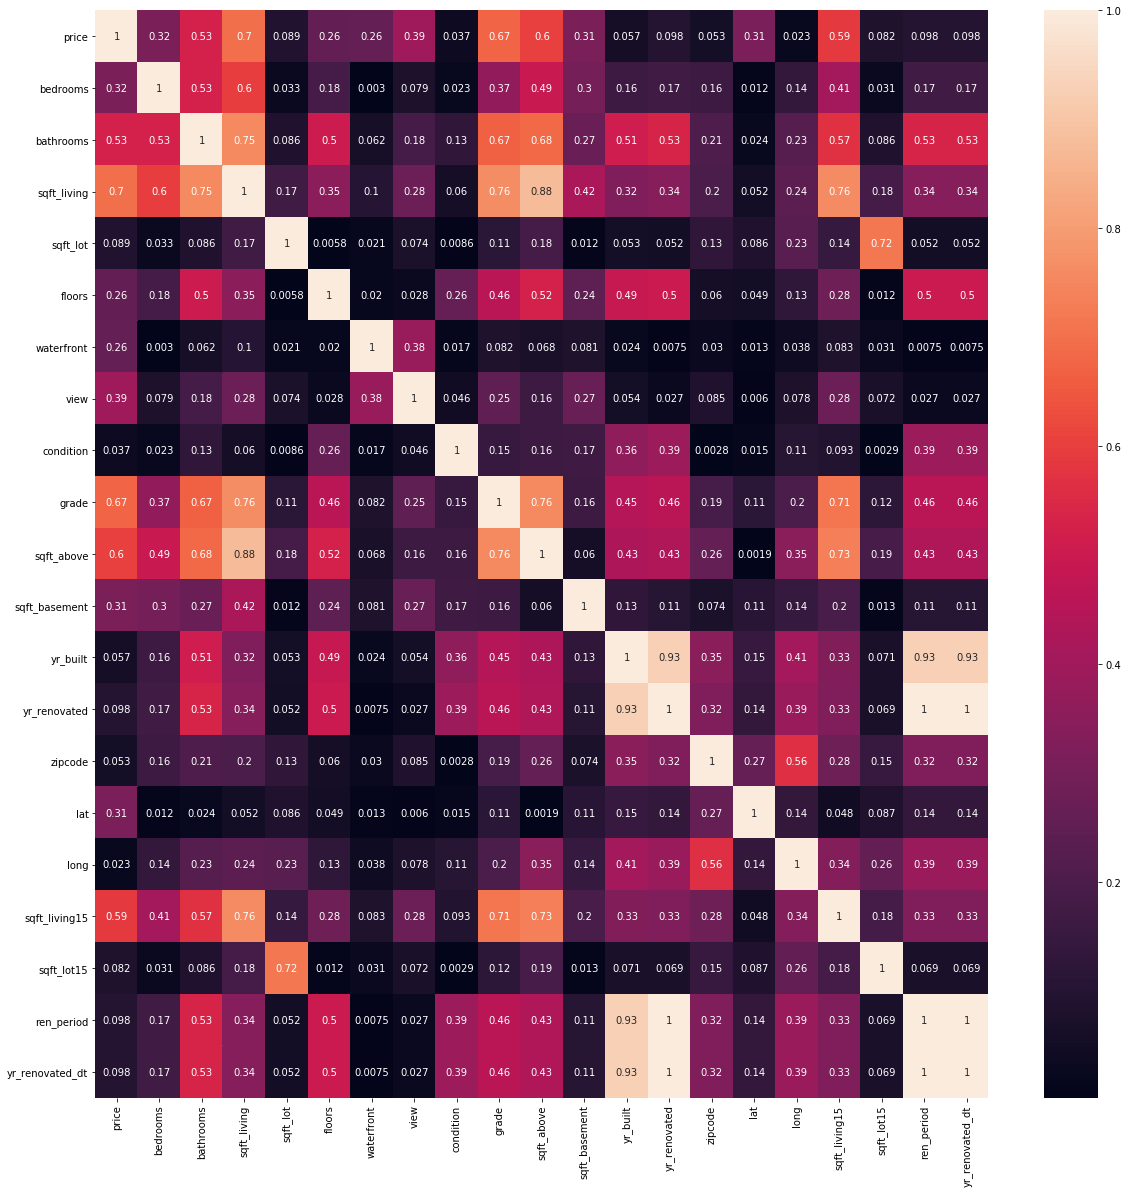

In [27]:
corr = dff_working.corr()
plt.figure(figsize=(20,20))
sns.heatmap(np.abs(corr), annot=True,)
plt.show()

Based on the above heatmap, we have determined:<br>
__*'sqft_living'*__ and __*'bathrooms*__ are highly correlated so we will combine them into one feature<br>
 
__*grade*__ also seems to have high correlation with other variables, so we will combine it with __*sqft_living15*__<br>

In [ ]:
weights = np.linspace(0, 1, 10000)
max_corr = -1
desired_weights = None
for weight in weights:
    weight1 = weight
    weight2 = 1 - weight
    vals = weight1*dff_working.grade + weight2*dff_working.sqft_living15
    corr_coeff = np.abs(np.corrcoef(vals, dff_working.price))[0][1]
    if corr_coeff > max_corr:
        desired_weights = [weight1, weight2]
        max_corr = corr_coeff
desired_weights

dff_sqft_grade = pd.DataFrame()
dff_working['sqft_grade'] = (desired_weights[0]*dff_working.grade + desired_weights[1]*dff_working.sqft_living15).astype(dtype='int32')

In [ ]:
dff_working["grade_sqft"] = desired_weights[0]*dff_working.bathrooms + desired_weights[1] * dff_working.sqft_living

In [ ]:
_workingweights = np.linspace(0, 1, 10000)
max_corr = -1
desired_weights = None
for weight in weights:
    weight1 = weight
    weight2 = 1 - weight
    vals = weight1*dff_working.bathrooms + weight2*dff_working.sqft_living
    corr_coeff = np.abs(np.corrcoef(vals, dff_working.price))[0][1]
    if corr_coeff > max_corr:
        desired_weights = [weight1, weight2]
        max_corr = corr_coeff
desired_weights

df_sqft_bath = pd.DataFrame()
dff_working['sqft_bath'] = (desired_weights[0]*dff_working.bathrooms + desired_weights[1]*dff_working.sqft_living).astype(dtype='int32')

In [ ]:
dff_working.head()

In [ ]:
#checking to see if there are any noticeable changes
corr = dff_working.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True,)
plt.show()

- It looks like we got rid of the multicolinearity.

In [ ]:
cols = ['sqft_grade', 'sqft_bath', 'ren_period', 'condition']
make_ols_model(df=dff_working, target='price', columns_to_use=cols, summary=True)

### Now let's separate the data into categorical and continuous


In [ ]:
# Much of the coninuous data seems to be very skewed.  
# We will perform a log transformation in an effort to normalize the data
data_log = pd.DataFrame([])
data_log["logsqft_lot"] = np.log(dff_working["sqft_lot"])
#data_log["logsqft_living"] = np.log(df_working["sqft_living"])
data_log["logyr_built"] = np.log(dff_working["yr_built"])
# data_log["loggrade"] = np.log(df_working["grade"])
data_log.hist(figsize  = [8, 4]);

In [ ]:
log_sqft_lot = data_log['logsqft_lot']
#log_sqft_living = data_log['logsqft_living']
log_yr_built = data_log['logyr_built']

scaled_log_sqft_lot = (log_sqft_lot-min(log_sqft_lot))/(max(log_sqft_lot)-min(log_sqft_lot))
#scaled_log_sqft_living = (log_sqft_living-min(log_sqft_living))/(max(log_sqft_living)-min(log_sqft_living))
scaled_log_yr_built = (log_yr_built-min(log_yr_built))/(max(log_yr_built)-min(log_yr_built))

In [ ]:
data_cont_scaled = pd.DataFrame([])
data_cont_scaled["log_sqft_lot"]= scaled_log_sqft_lot
# data_cont_scaled["log_sqft_living"] = scaled_log_sqft_living
data_cont_scaled["log_yr_built"] = scaled_log_yr_built

In [ ]:
data_cont_scaled.hist(figsize  = [8,4])

#### This seems to have made a difference in the data.

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,3))

for xcol, ax in zip(['sqft_lot', 'yr_built'], axes):
    dff.plot(kind='scatter', x=xcol, y='price', ax=ax, alpha=0.4, color='b')
    


### From this plot, we have learned<br>
- __*'sqft_living'*__ will be a good predictor<br>
- __*'Sqft_lot'*__ may be affecting the results adversely<br>
- __*'bedrooms'*__ looks significant as well as __*'bathrooms'*__<br>


### There are many categorical variables, so we need to handle those here
- We will change them to categories
- Perform One_Hot encoding to normalize the data

### Here we are dealing with the categorical values and making them easier to work with

In [ ]:
df_cat = pd.DataFrame([])
#df_cat['bathrooms'] = df_working['bathrooms'].astype('category')
df_cat['bedrooms'] = df_working['bedrooms'].astype('category')
df_cat['floors'] = df_working['floors'].astype('category')
df_cat['waterfront'] = df_working['waterfront'].astype('category')
df_cat['view'] = df_working['view'].astype('category')
df_cat['condition'] = df_working['condition'].astype('category')
#df_cat['grade'] = df_working['grade'].astype('category')
# df_cat['grade'] = df_working['grade'].astype('category')
df_cat.info()


In [ ]:
#df_cat['bathrooms'].cat.codes
df_cat['bedrooms'].cat.codes
df_cat['floors'].cat.codes
df_cat['waterfront'].cat.codes
df_cat['view'].cat.codes
df_cat['condition'].cat.codes
#df_cat['grade'].cat.codes
df_cat.info()

In [ ]:
# bins = [0, 1, 2, 3, 10]

# bins_bathrooms = pd.cut(df_cat['bathrooms'], bins)
# bins_bathrooms = bins_bathrooms.cat.as_unordered()

In [ ]:
bins = [0, 1, 2, 4, 6]

bins_bedrooms = pd.cut(df_cat['bedrooms'], bins)
bins_bedrooms = bins_bedrooms.cat.as_unordered()

In [ ]:

bins = [0, 1, 2, 4]

bins_floors = pd.cut(df_cat['floors'], bins)
bins_floors = bins_floors.cat.as_unordered()

In [ ]:
bins = [0, 1, 4]

bins_waterfront = pd.cut(df_cat['waterfront'], bins)
bins_waterfront = bins_waterfront.cat.as_unordered()

In [ ]:
bins = [0, 1, 2, 4, 5, 7]

bins_view = pd.cut(df_cat['view'], bins)
bins_view = bins_view.cat.as_unordered()

In [ ]:
# bins = [0, 3, 4, 5, 9 ]

# bins_grade = pd.cut(df_cat['grade'], bins)
# bins_grade = bins_grade.cat.as_unordered()

In [ ]:
bins = [0, 2, 3, 4, 6]

bins_condition = pd.cut(df_cat['condition'], bins)
bins_condition = bins_condition.cat.as_unordered()

In [ ]:
#dummy_bathrooms = pd.get_dummies(bins_bathrooms, prefix="BATH", drop_first=True)
dummy_bedrooms = pd.get_dummies(bins_bedrooms, prefix="BED", drop_first=True)
dummy_floors = pd.get_dummies(bins_floors, prefix="FLOR", drop_first=True)
dummy_waterfront = pd.get_dummies(bins_waterfront, prefix="WATER", drop_first=True)
dummy_view = pd.get_dummies(bins_view, prefix="VW", drop_first=True)
dummy_condition = pd.get_dummies(bins_condition, prefix="COND", drop_first=True)
#dummy_grade = pd.get_dummies(bins_grade, prefix="GRAD", drop_first=True)
df_dummy = pd.concat([dummy_bedrooms, dummy_floors, dummy_view, dummy_waterfront, dummy_condition], axis=1) 

In [ ]:
df_final = pd.concat([df_working.price, data_cont_scaled, df_dummy, df_sqft_bath, df_sqft_grade], axis=1, )
df_final.to_csv('KC_Data_Final.csv', index=False)
df_final.info()

### The dummy values created column names which contain characters that do not agree with coding<br>
- they are being modified below.

In [ ]:
df_final.rename(columns={'BED_(1, 2]': 'bed1', 'BED_(2, 4]': 'bed2', 'BED_(4, 6]': 'bed4',
                         'FLOR_(1, 2]': 'flor1', 'FLOR_(2, 4]': 'flor2',
                         'VW_(1, 2]': 'vw1', 'VW_(2, 4]': 'vw2', 'VW_(4, 5]': 'vw4', 'VW_(5, 7]': 'vw5',
                         'WATER_(1, 4]': 'water1',
                         'COND_(2, 3]': 'cond2', 'COND_(3, 4]': 'cond3', 'COND_(4, 6]': 'cond4',
                         0: 'sqft_bath', 1: 'sqft_grade'
}, inplace=True)
df_final.head()

### Now that we have the data organized, lets start looking at the relationships.

In [ ]:
sns.lmplot(x='price', y='sqft_bath', data=df_final)

In [ ]:
#### looks like we have some outliers that may be skewing the data.  We will take a look at that here:
removedf = df_final.loc[(df_final.sqft_bath > 10000) & (df_final.price > 500000)]
df_test = df_sqft_bath.iloc[(index not in removedf.index for index in df_final.index)]
sns.lmplot(x='price', y='sqft_bath', data=df_test)

In [ ]:
df_final.head()

In [ ]:
for column in ['log_sqft_lot', 'log_yr_built', 'sqft_bath', 'sqft_grade']:
    df_final[column].plot.hist(normed=True, color='lightblue' )
    df_final[column].plot.kde(label=column, color='darkblue' )
    plt.legend()
    plt.show()

In [ ]:
for column in ['log_sqft_lot', 'log_yr_built', 'sqft_bath', 'sqft_grade']:
    sns.lmplot(x=column, y="price",
                  data=df_final)
    plt.show()

In [ ]:
df_final.fillna(0, inplace=True)
df_final = df_final['sqft_grade'].fillna(0)

In [ ]:
#df_final.drop(['bed1', 'bed2', 'bed4'], axis=1, inplace=True)

In [ ]:
# x = df_final['price']
# y = df_final['water1']
# sns.catplot(x=x, y=y,
#             kind="box", dodge=False, data=df_final);

In [ ]:
corr = df_final.corr()
plt.figure(figsize=(20,20))
sns.heatmap(corr, annot=True,)
plt.show()

In [ ]:
df_final.head()

In [ ]:
col_names = df_final.describe().columns.drop(['price'])
results = [['ind_var', 'r_squared', 'intercept', 'slope', 'p-value' ]]
for idx, val in enumerate(col_names):
    print ("Price~" + val)
    print ("------------------------------")

    f = 'price~' + val
    model = smf.ols(formula=f, data=df_final).fit()
    X_new = pd.DataFrame({val: [df_final[val].min(), df_final[val].max()]});
    preds = model.predict(X_new)
    results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
    print (results[idx+1])

In [ ]:
pd.DataFrame(results)

In [ ]:
y = df_final[['price']]
X = df_final.drop(['price'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=31)

In [ ]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

In [ ]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [ ]:
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [ ]:
mse_train = np.sum((y_train-y_hat_train)**2)/len(y_train)
mse_test = np.sum((y_test-y_hat_test)**2)/len(y_test)
print('Train Mean Squarred Error:', mse_train)
print('Test Mean Squarred Error:', mse_test)

In [ ]:
linreg.fit(X_train, y_train)

In [ ]:
print(linreg.intercept_)

In [ ]:
y_pred = linreg.predict(X_test)

In [ ]:
print(metrics.mean_absolute_error(y_test, y_pred))
print(metrics.mean_squared_error(y_test, y_pred))
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

In [ ]:
num = 20
train_err = []
test_err = []
for i in range(num):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test)
    train_err.append(metrics.mean_squared_error(y_train, y_hat_train))
    test_err.append(metrics.mean_squared_error(y_test, y_hat_test))
plt.scatter(list(range(num)), train_err, label='Training Error')
plt.scatter(list(range(num)), test_err, label='Testing Error')
plt.legend();

In [ ]:
cv_5_results  = np.mean(cross_val_score(linreg, X, y, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X, y, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X, y, cv=20, scoring='neg_mean_squared_error'))

In [ ]:
print(cv_5_results)

In [ ]:
df_final.head()

In [ ]:

y = df_final.price
X = df_final.logsqft_living
sm.add_constant(X)
sm.OLS(y, X).fit()
results.append([val, model.rsquared, model.params[0], model.params[1], model.pvalues[1]])
pd.DataFrame(results)


In [ ]:
target = 'price'
x_cols = df_final.drop('price', axis=1).columns
predictors = '+'.join(x_cols)
formula = target + '~' + predictors
model = ols(formula=formula, data=df_final).fit()
model.summary()

In [ ]:
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("equal")

# Draw the two density plots
ax = sns.kdeplot(df.price, df.lat,
                 cmap="Reds", shade=True, shade_lowest=False)
ax = sns.kdeplot(df.price, df.long,
                 cmap="Blues", shade=True, shade_lowest=False)

### Model building

In [ ]:
ols, summary = ols_model(dff_working, columns_to_use=['sqft_living', 'grade'], add_constant=False)

In [ ]:
ols.fit().summary()

### The best model
* normal distributions of data going in
* scaled data (if you choose to do so)

In [ ]:
dff_working['log_sqft_living'] = np.log(dff_working['sqft_living'])

In [ ]:
plt.hist(dff_working.sqft_living)
plt.show()
plt.hist(dff_working.log_sqft_living)
plt.show()

In [ ]:
ols, summary = ols_model(df=dff_working, columns_to_use=['log_sqft_living', 'grade'], add_constant=False)
ols.fit().summary()